## seaborn

In [1]:
import anndata as ad
import numpy as np

In [2]:
import sys
import os

# Define the path to the main folder
main_folder = "/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/main"

# Add it to sys.path
sys.path.append(main_folder)

import LCL_eval

In [3]:
input_dir = "/Users/apple/Desktop/KB/data"

train_10 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04_10/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_10 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04_10/test_embedding.npy')

train_32 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04_32/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_32 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04_32/test_embedding.npy')

train_200 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0217_Larry_top200_sf04_200/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_200 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0217_Larry_top200_sf04_200/test_embedding.npy')

train_250 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04_250/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_250 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04_250/test_embedding.npy')

train_64 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_64 = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04/test_embedding.npy')

train_sig = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04_sigmoid_last/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_sig = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04_sigmoid_last/test_embedding.npy')

train_att = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04_attention/scBaseEncoderFeat_Z_bs150_tau0.5.npy')
test_att = np.load(input_dir+'/feat_LCL_2025/Larry_top200/feat_0204_Larry_top200_sf04_attention/test_embedding.npy')


adata_train = ad.read_h5ad(input_dir+'/LarryData/train_test/Larry_200_train.h5ad')
adata_test = ad.read_h5ad(input_dir+'/LarryData/train_test/Larry_200_test.h5ad')

### Embedding of dim 10

In [4]:
adata_train.obsm["LCL_embedding_dim10"] = train_10
adata_test.obsm["LCL_embedding_dim10"] = test_10

adata_train.obs["dataset"] = "train"
adata_test.obs["dataset"] = "test"

adata = ad.concat([adata_train, adata_test], axis=0, join='outer')

In [5]:
import umap

reducer = umap.UMAP()

embedding_umap = reducer.fit_transform(adata.obsm["LCL_embedding_dim10"])

adata.obsm["X_umap"] = embedding_umap

In [6]:
adata.write("anndata_train_test_dim10.h5ad")

In [ ]:
import umap

reducer = umap.UMAP()

embedding_umap = reducer.fit_transform(adata.obsm["LCL_embedding_dim10"])

adata.obsm["X_umap"] = embedding_umap

In [13]:
import pandas as pd

# Count number of cells per lineage
clone_counts = adata.obs["clone_id"].value_counts()

# Get the top 5 largest lineages
top_5_clones = clone_counts.index[:5]

# Assign 'Other' to all lineages except the top 5
adata.obs["clone_group"] = adata.obs["clone_id"].apply(lambda x: x if x in top_5_clones else "Other")

# Convert to categorical
adata.obs["clone_group"] = adata.obs["clone_group"].astype("category")

# Print for verification
print(adata.obs["clone_group"].value_counts())

clone_group
Other    10627
1261       177
2370       165
5714       141
292        134
5209       129
Name: count, dtype: int64


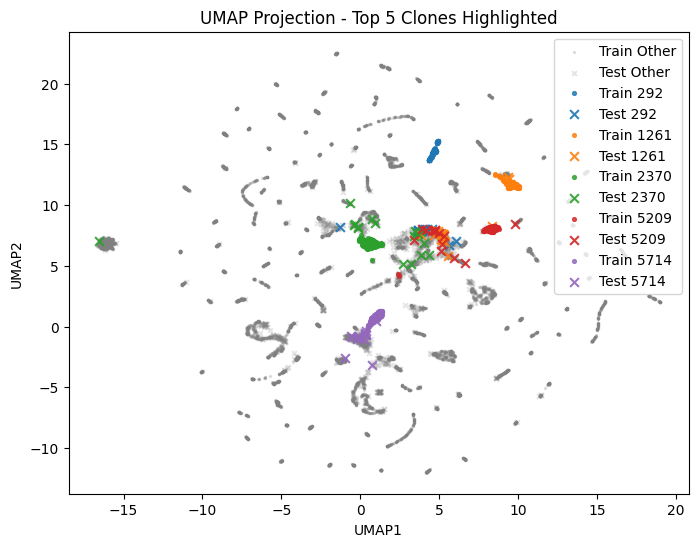

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_umap(adata, colormap="tab10"):
    """
    Plots UMAP with:
    - Top 5 clones in distinct colors (plotted on top)
    - Other clones in gray with lower opacity
    - Train cells as dots, Test cells as crosses
    - Larger marker size for top 5 clones
    """
    umap_coords = adata.obsm["X_umap"]

    # Extract train and test indices
    train_idx = adata.obs["dataset"] == "train"
    test_idx = adata.obs["dataset"] == "test"

    # Get unique clone groups
    unique_clones = adata.obs["clone_group"].cat.categories

    # Define a colormap for the top 5 clones, others in gray
    colors = plt.get_cmap(colormap)(range(len(unique_clones) - 1))  # Leave space for gray
    color_map = dict(zip(unique_clones[:-1], colors))  # Map top 5 clones
    color_map["Other"] = "gray"  # Set 'Other' to gray

    plt.figure(figsize=(8, 6))

    # **Step 1**: Plot "Other" cells first (background with low opacity)
    idx_train_other = (adata.obs["clone_group"] == "Other") & train_idx
    idx_test_other = (adata.obs["clone_group"] == "Other") & test_idx

    plt.scatter(umap_coords[idx_train_other, 0], umap_coords[idx_train_other, 1], 
                color=color_map["Other"], s=8, marker=".", alpha=0.2, label="Train Other")  # Lower opacity

    plt.scatter(umap_coords[idx_test_other, 0], umap_coords[idx_test_other, 1], 
                color=color_map["Other"], s=12, marker="x", alpha=0.2, label="Test Other")  # Lower opacity

    # **Step 2**: Plot top 5 clones on top (larger size)
    for clone in unique_clones[:-1]:  # Skip "Other"
        idx_train = (adata.obs["clone_group"] == clone) & train_idx
        idx_test = (adata.obs["clone_group"] == clone) & test_idx

        # Train: Dots
        plt.scatter(umap_coords[idx_train, 0], umap_coords[idx_train, 1], 
                    color=color_map[clone], s=30, marker=".", alpha=0.8, label=f"Train {clone}")  # Bigger size

        # Test: Crosses
        plt.scatter(umap_coords[idx_test, 0], umap_coords[idx_test, 1], 
                    color=color_map[clone], s=40, marker="x", alpha=0.9, label=f"Test {clone}")  # Bigger size

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title("UMAP Projection - Top 5 Clones Highlighted")
    plt.legend()
    plt.show()

# Run the function to plot
plot_umap(adata)

### Train 

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_umap_with_lineages(adata, n_top_lineages=5, colormap="tab10"):
    """
    Plots UMAP from `adata.obsm["X_umap"]` with:
    - Top N clones in distinct colors (plotted on top)
    - Other clones in gray with lower opacity
    - Train cells as dots, Test cells as crosses
    
    Parameters:
    - adata (AnnData): AnnData object with precomputed UMAP in `.obsm["X_umap"]`
    - n_top_lineages (int): Number of largest lineages to highlight in the plot
    - colormap (str): Matplotlib colormap for the distinct top N lineages
    
    Output:
    - A UMAP scatter plot (does NOT modify `adata`)
    """

    ### **1️⃣ Check If Required Fields Exist**
    if "X_umap" not in adata.obsm:
        raise ValueError("UMAP coordinates missing! Ensure `adata.obsm['X_umap']` is computed.")
    
    if "LCL_embedding_dim10" not in adata.obsm:
        raise ValueError("Contrastive learning embeddings missing! Ensure `adata.obsm['LCL_embedding_dim10']` exists.")
    
    if "clone_id" not in adata.obs:
        raise ValueError("Clone ID column missing! Ensure `adata.obs['clone_id']` exists.")
    
    if "dataset" not in adata.obs:
        raise ValueError("Dataset column missing! Ensure `adata.obs['dataset']` exists with 'train' and 'test' values.")

    ### **2️⃣ Identify the Top N Largest Lineages**
    print(f"Identifying the top {n_top_lineages} largest lineages...")
    clone_counts = adata.obs["clone_id"].value_counts()
    top_n_clones = clone_counts.index[:n_top_lineages]

    # Assign "Other" to all but the top N lineages
    adata.obs["clone_group"] = adata.obs["clone_id"].apply(lambda x: x if x in top_n_clones else "Other")
    
    # Convert to categorical for easy plotting
    adata.obs["clone_group"] = adata.obs["clone_group"].astype("category")

    ### **3️⃣ Plot UMAP with Custom Formatting**
    print("Plotting UMAP with lineage-specific colors and train/test markers...")

    umap_coords = adata.obsm["X_umap"]
    train_idx = adata.obs["dataset"] == "train"
    test_idx = adata.obs["dataset"] == "test"
    
    unique_clones = adata.obs["clone_group"].cat.categories

    # Define a colormap for the top N clones, others in gray
    colors = plt.get_cmap(colormap)(range(len(unique_clones) - 1))  # Leave space for gray
    color_map = dict(zip(unique_clones[:-1], colors))  # Map top N clones
    color_map["Other"] = "gray"  # Set 'Other' to gray

    plt.figure(figsize=(8, 6))

    # **Step 1**: Plot "Other" cells first (background with low opacity)
    idx_train_other = (adata.obs["clone_group"] == "Other") & train_idx
    idx_test_other = (adata.obs["clone_group"] == "Other") & test_idx

    plt.scatter(umap_coords[idx_train_other, 0], umap_coords[idx_train_other, 1], 
                color=color_map["Other"], s=8, marker=".", alpha=0.2, label="Train Other")

    plt.scatter(umap_coords[idx_test_other, 0], umap_coords[idx_test_other, 1], 
                color=color_map["Other"], s=8, marker="x", alpha=0.2, label="Test Other")

    # **Step 2**: Plot top N clones on top (larger size)
    for clone in unique_clones[:-1]:  # Skip "Other"
        idx_train = (adata.obs["clone_group"] == clone) & train_idx
        idx_test = (adata.obs["clone_group"] == clone) & test_idx

        # Train: Dots
        plt.scatter(umap_coords[idx_train, 0], umap_coords[idx_train, 1], 
                    color=color_map[clone], s=40, marker=".", alpha=0.8, label=f"Train {clone}")

        # Test: Crosses
        plt.scatter(umap_coords[idx_test, 0], umap_coords[idx_test, 1], 
                    color=color_map[clone], s=40, marker="x", alpha=1, label=f"Test {clone}")

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(f"UMAP Projection - Top {n_top_lineages} Clones Highlighted")
    plt.legend()
    plt.show()

Identifying the top 1 largest lineages...
Plotting UMAP with lineage-specific colors and train/test markers...


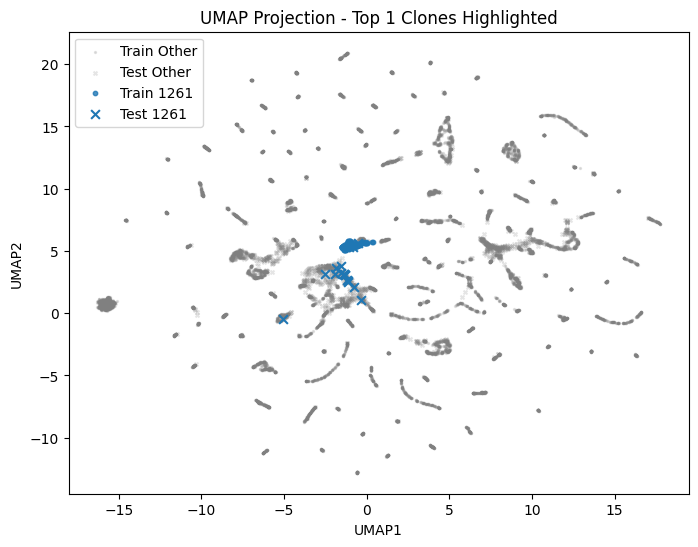

In [13]:
plot_umap_with_lineages(adata, n_top_lineages=1)

In [ ]:
embed_10 = np.concatenate((train_10, test_10), axis=0)
adata = ad.concat([adata_train, adata_test], axis=0, join='outer')
eval_08_embed = LCL_eval.Eval(embed_10, adata)
eval_08_embed.plot_umap_top_lin("size factor 08")

In [ ]:
import umap
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(embed_10)
adata.obsm["X_umap"] = embedding_umap 

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(embedding_umap[:,0],embedding_umap[:,1])

In [ ]:
plt.scatter(embedding_umap[:10147,0],embedding_umap[:10147,1])

In [ ]:
plt.scatter(embedding_umap[10148:,0],embedding_umap[10148:,1])

In [ ]:
eval_sig_train = LCL_eval.Eval(train_sig, adata_train)
eval_sig_train.plot_umap_top_lin("size factor 005 Train")
eval_sig_train.KNN_train()
score_sig_train = eval_sig_train.calculate_calinski_harabasz_score()

In [ ]:
eval_sig_test = LCL_eval.Eval(test_sig, adata_test)
eval_sig_test.plot_umap_top_lin("size factor 005 Test")
score_sig_test = eval_sig_test.calculate_calinski_harabasz_score()
eval_sig_train.KNN_test(test_sig, adata_test)

In [ ]:
train_sig[0:9,0:9]

In [ ]:
eval_10_train = LCL_eval.Eval(train_10, adata_train)
eval_10_train.plot_umap_top_lin("size factor 01 Train")
eval_10_train.KNN_train()
score_10_train = eval_10_train.calculate_calinski_harabasz_score()

In [ ]:
eval_10_test = LCL_eval.Eval(test_10, adata_test)
eval_10_test.plot_umap_top_lin("size factor 005 Test")
score_10_test = eval_10_test.calculate_calinski_harabasz_score()
eval_10_train.KNN_test(test_10, adata_test)

In [ ]:
eval_32_train = LCL_eval.Eval(train_32, adata_train)
eval_32_train.plot_umap_top_lin("size factor 01 Train")
eval_32_train.KNN_train()
score_32_train = eval_32_train.calculate_calinski_harabasz_score()

In [ ]:
eval_32_test = LCL_eval.Eval(test_32, adata_test)
eval_32_test.plot_umap_top_lin("size factor 005 Test")
score_32_test = eval_32_test.calculate_calinski_harabasz_score()
eval_32_train.KNN_test(test_32, adata_test)

In [ ]:
eval_200_train = LCL_eval.Eval(train_200, adata_train)
eval_200_train.plot_umap_top_lin("size factor 01 Train")
eval_200_train.KNN_train()
score_200_train = eval_200_train.calculate_calinski_harabasz_score()

In [ ]:
eval_200_test = LCL_eval.Eval(test_200, adata_test)
eval_200_test.plot_umap_top_lin("size factor 005 Test")
score_200_test = eval_200_test.calculate_calinski_harabasz_score()
eval_200_train.KNN_test(test_200, adata_test)

In [ ]:
eval_250_train = LCL_eval.Eval(train_250, adata_train)
eval_250_train.plot_umap_top_lin("size factor 01 Train")
eval_250_train.KNN_train()
score_250_train = eval_250_train.calculate_calinski_harabasz_score()

In [ ]:
eval_250_test = LCL_eval.Eval(test_250, adata_test)
eval_250_test.plot_umap_top_lin("size factor 005 Test")
score_250_test = eval_250_test.calculate_calinski_harabasz_score()
eval_250_train.KNN_test(test_250, adata_test)

In [ ]:
eval_att_train = LCL_eval.Eval(train_att, adata_train)
eval_att_train.plot_umap_top_lin("size factor 01 Train")
eval_att_train.KNN_train()
score_att_train = eval_att_train.calculate_calinski_harabasz_score()

In [ ]:
eval_att_test = LCL_eval.Eval(test_att, adata_test)
eval_att_test.plot_umap_top_lin("size factor 005 Test")
score_att_test = eval_att_test.calculate_calinski_harabasz_score()
eval_att_train.KNN_test(test_att, adata_test)